# Quantum Current Plateau Search via Bayesian Optimization (V8 Final v2)

## Optimized Model: Wide n=1 Plateau, No n=0.5 Plateau

### Key Features:
- **Configurable filter tolerances** for consistent filtering across all plots
- **Dual GP**: One for cost (optimization), one for n (visualization)
- **Full legends** on all 2D density maps
- **True GP variance** at actual 3D BO measurement locations

### Physics Model:
$$n_{exit} = \exp\left[-\exp\left(-\frac{V-V_a}{V_b}\right)\right] + \exp\left[-\exp\left(-\frac{V-V_a+\delta_2}{V_b}\right)\right]$$

### References:
- Ahn et al., J. Appl. Phys. 122, 194502 (2017)
- Bae et al., Metrologia 57, 065025 (2020)

In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from pathlib import Path
from datetime import datetime
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

FORCE_SIMULATION = True

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.optimize import minimize
from scipy.stats import norm

print('V8 Final v2 - Configurable filters + Consistent filtering')

V8 Final v2 - Configurable filters + Consistent filtering


In [2]:
# Cell 2: Configuration - FILTER PARAMETERS HERE!

class Config:
    """Experiment configuration with user-adjustable parameters"""
    
    # ========== FILTER TOLERANCES (ADJUST THESE!) ==========
    # Used for selecting BO points near a reference point in all plots
    V_ENT_TOLERANCE = 0.03   # ±30mV (try 0.01 for ±10mV, 0.02 for ±20mV)
    V_P_TOLERANCE = 0.03    # ±30mV (try 0.01 for ±10mV, 0.02 for ±20mV)
    # =========================================================
    
    # Physical constants
    e = 1.602176634e-19
    f = 0.350540506e9
    
    @property
    def target_current(self):
        return self.e * self.f
    
    # Gate voltage bounds [V_ENT, V_P, V_EXIT]
    bounds = np.array([
        [-0.75, -0.50],
        [-0.75, -0.50],
        [-0.80, -0.50]
    ])
    
    # BO parameters
    n_initial_points = 20
    n_iterations = 80
    early_stop_patience = 25
    
    # Logging
    log_dir = Path('./experiment_logs_v8')
    experiment_name = f'BO_V8_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    
    @classmethod
    def print_filter_settings(cls):
        print('='*60)
        print('FILTER SETTINGS')
        print('='*60)
        print(f'V_ENT tolerance: ±{cls.V_ENT_TOLERANCE*1000:.0f} mV')
        print(f'V_P tolerance:   ±{cls.V_P_TOLERANCE*1000:.0f} mV')
        print('='*60)


class OptimizedPumpModel:
    """V8 Optimized Pump Model"""
    
    def __init__(self):
        self.Va_base = -0.66
        self.Vb = 0.008
        self.delta2 = 0.10
        self.cross_coupling_ent = 0.30
        self.V_ent_ref = -0.62
        self.V_ent_center = -0.62
        self.ent_width = 0.20
        self.ent_sharpness = 100.0
        self.V_p_center = -0.63
        self.p_width = 0.20
        self.p_sharpness = 80.0
        self.noise_std = 1e-7
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def effective_Va(self, V_ent):
        return self.Va_base + self.cross_coupling_ent * (V_ent - self.V_ent_ref)
    
    def f_exit(self, V_exit, V_ent):
        Va_eff = self.effective_Va(V_ent)
        arg1 = np.clip(-(V_exit - Va_eff) / self.Vb, -100, 100)
        arg2 = np.clip(-(V_exit - Va_eff + self.delta2) / self.Vb, -100, 100)
        return np.exp(-np.exp(arg1)) + np.exp(-np.exp(arg2))
    
    def f_entrance(self, V_ent):
        V_L = self.V_ent_center - self.ent_width / 2
        V_R = self.V_ent_center + self.ent_width / 2
        return self.sigmoid(self.ent_sharpness * (V_ent - V_L)) * self.sigmoid(-self.ent_sharpness * (V_ent - V_R))
    
    def f_plunger(self, V_p):
        V_L = self.V_p_center - self.p_width / 2
        V_R = self.V_p_center + self.p_width / 2
        return self.sigmoid(self.p_sharpness * (V_p - V_L)) * self.sigmoid(-self.p_sharpness * (V_p - V_R))
    
    def calculate_n_avg(self, V_ent, V_p, V_exit):
        n = self.f_exit(V_exit, V_ent) * self.f_entrance(V_ent) * self.f_plunger(V_p)
        return n + np.random.normal(0, self.noise_std)
    
    def calculate_current(self, V_ent, V_p, V_exit, config):
        return self.calculate_n_avg(V_ent, V_p, V_exit) * config.e * config.f


# Print current filter settings
Config.print_filter_settings()
print('\nModel defined')

FILTER SETTINGS
V_ENT tolerance: ±30 mV
V_P tolerance:   ±30 mV

Model defined


In [3]:
# Cell 3: Controllers

class InstrumentController:
    def __init__(self, config):
        self.config = config
        self.model = OptimizedPumpModel()
        print('Mode: SIMULATION')
    
    def measure_current(self, V_ent, V_p, V_exit):
        return self.model.calculate_current(V_ent, V_p, V_exit, self.config)


class BayesianOptimizer:
    """BO with two GPs: one for cost (optimization), one for n (visualization)"""
    
    def __init__(self, bounds):
        self.bounds = bounds
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-5)
        
        self.gp_cost = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=10, normalize_y=True
        )
        self.gp_n = GaussianProcessRegressor(
            kernel=ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-5),
            n_restarts_optimizer=10, normalize_y=True
        )
        
        self.X = []
        self.y_cost = []
        self.y_n = []
        self.is_fitted = False
    
    def fit(self, X, y_cost, y_n=None):
        self.X = np.array(X)
        self.y_cost = np.array(y_cost)
        self.gp_cost.fit(self.X, self.y_cost)
        
        if y_n is not None:
            self.y_n = np.array(y_n)
            self.gp_n.fit(self.X, self.y_n)
        
        self.is_fitted = True
    
    def predict_cost(self, X):
        if not self.is_fitted:
            return None, None
        return self.gp_cost.predict(np.atleast_2d(X), return_std=True)
    
    def predict_n(self, X):
        if not self.is_fitted or len(self.y_n) == 0:
            return None, None
        return self.gp_n.predict(np.atleast_2d(X), return_std=True)
    
    def _expected_improvement(self, x):
        x = np.atleast_2d(x)
        mu, sigma = self.gp_cost.predict(x, return_std=True)
        sigma = np.maximum(sigma, 1e-9)
        y_best = np.min(self.y_cost)
        Z = (y_best - mu) / sigma
        return -((y_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z))[0]
    
    def suggest(self):
        best_x, best_ei = None, np.inf
        for _ in range(20):
            x0 = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1])
            res = minimize(self._expected_improvement, x0, bounds=self.bounds, method='L-BFGS-B')
            if res.fun < best_ei:
                best_ei, best_x = res.fun, res.x
        return best_x


class DataLogger:
    def __init__(self, config):
        config.log_dir.mkdir(parents=True, exist_ok=True)
        self.log_file = config.log_dir / f'{config.experiment_name}.csv'
        with open(self.log_file, 'w') as f:
            f.write('iteration,V_ent,V_p,V_exit,n_avg,cost\n')
    
    def log(self, i, V_ent, V_p, V_exit, n_avg, cost):
        with open(self.log_file, 'a') as f:
            f.write(f'{i},{V_ent},{V_p},{V_exit},{n_avg},{cost}\n')


class EarlyStopping:
    def __init__(self, patience=20):
        self.patience, self.best, self.counter = patience, np.inf, 0
    
    def update(self, cost):
        if cost < self.best - 1e-5:
            self.best, self.counter = cost, 0
        else:
            self.counter += 1
        return self.counter >= self.patience


def filter_near_points(X_hist, y_hist, n_hist, V_ent_ref, V_p_ref, config):
    """
    Consistent filtering function used across all plots.
    
    Returns points where:
    - |V_ENT - V_ent_ref| < V_ENT_TOLERANCE
    - |V_P - V_p_ref| < V_P_TOLERANCE
    """
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    mask = ((np.abs(X_hist[:, 0] - V_ent_ref) < config.V_ENT_TOLERANCE) & 
            (np.abs(X_hist[:, 1] - V_p_ref) < config.V_P_TOLERANCE))
    
    return X_hist[mask], y_hist[mask], n_hist[mask], mask


print('Controllers defined')
print('filter_near_points() will use Config.V_ENT_TOLERANCE and Config.V_P_TOLERANCE')

Controllers defined
filter_near_points() will use Config.V_ENT_TOLERANCE and Config.V_P_TOLERANCE


In [4]:
# Cell 4: Visualization Functions - CONSISTENT FILTERING

def generate_pump_map(model, config, v_p_fixed=-0.63, resolution=150):
    v_ent_range = np.linspace(config.bounds[0, 0], config.bounds[0, 1], resolution)
    v_exit_range = np.linspace(config.bounds[2, 0], config.bounds[2, 1], resolution)
    V_ENT, V_EXIT = np.meshgrid(v_ent_range, v_exit_range)
    n_map = np.zeros_like(V_ENT)
    for i in range(resolution):
        for j in range(resolution):
            n_map[i, j] = (model.f_exit(V_EXIT[i, j], V_ENT[i, j]) * 
                          model.f_entrance(V_ENT[i, j]) * model.f_plunger(v_p_fixed))
    return V_ENT, V_EXIT, n_map


def plot_error_analysis_with_GP_variance(model, config, X_hist, y_hist, n_hist, bo,
                                          V_ent_fixed, V_p_fixed,
                                          n_gp_points=100, save_data=True):
    """
    Error analysis with CONSISTENT filtering using Config tolerances.
    """
    
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    n_hist = np.array(n_hist)
    
    # Use consistent filtering
    X_near, y_near, n_near, mask = filter_near_points(
        X_hist, y_hist, n_hist, V_ent_fixed, V_p_fixed, config
    )
    n_filtered = len(X_near)
    
    print(f'Filtered points: {n_filtered} / {len(X_hist)} total')
    print(f'  V_ENT tolerance: ±{config.V_ENT_TOLERANCE*1000:.0f} mV from {V_ent_fixed:.3f} V')
    print(f'  V_P tolerance:   ±{config.V_P_TOLERANCE*1000:.0f} mV from {V_p_fixed:.3f} V')
    
    # Model curve (1D slice)
    V_exit_range = np.linspace(config.bounds[2, 0], config.bounds[2, 1], 500)
    n_model = np.array([model.f_exit(v, V_ent_fixed) * 
                        model.f_entrance(V_ent_fixed) * 
                        model.f_plunger(V_p_fixed) for v in V_exit_range])
    delta_model = np.clip(np.abs(n_model - 1), 1e-12, None)
    
    # GP predictions along 1D slice
    V_exit_gp = np.linspace(config.bounds[2, 0], config.bounds[2, 1], n_gp_points)
    X_gp = np.array([[V_ent_fixed, V_p_fixed, v] for v in V_exit_gp])
    
    gp_cost_mu, gp_cost_sigma = bo.predict_cost(X_gp)
    gp_cost_variance = gp_cost_sigma ** 2
    delta_gp = 10 ** gp_cost_mu
    delta_gp_upper = 10 ** (gp_cost_mu + gp_cost_sigma)
    delta_gp_lower = 10 ** (gp_cost_mu - gp_cost_sigma)
    
    gp_n_mu, gp_n_sigma = bo.predict_n(X_gp)
    
    # TRUE GP variance at actual BO measurement points
    if n_filtered > 0:
        _, sigma_at_meas = bo.predict_cost(X_near)
        var_at_meas = sigma_at_meas ** 2
    else:
        sigma_at_meas = np.array([])
        var_at_meas = np.array([])
    
    # ===== 3-PANEL PLOT =====
    fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
    
    # Panel title with filter info
    filter_info = f'Filter: $V_{{ENT}}$±{config.V_ENT_TOLERANCE*1000:.0f}mV, $V_P$±{config.V_P_TOLERANCE*1000:.0f}mV → {n_filtered} pts'
    
    # ----- (a) n vs V_EXIT -----
    ax = axes[0]
    ax.plot(V_exit_range, n_model, 'r-', lw=2.5, label='Physics Model', zorder=3)
    
    if gp_n_mu is not None:
        ax.plot(V_exit_gp, gp_n_mu, 'g--', lw=2, label='GP Prediction (on n)', zorder=2)
        ax.fill_between(V_exit_gp, gp_n_mu - gp_n_sigma, gp_n_mu + gp_n_sigma,
                        color='green', alpha=0.15, label='GP ±1σ')
    
    if n_filtered > 0:
        ax.scatter(X_near[:, 2], n_near, c='steelblue', s=60, edgecolors='k', 
                   linewidths=0.5, zorder=5, label=f'BO Measurements ({n_filtered} pts)')
    
    ax.axhline(1, color='gray', ls='--', alpha=0.5, label='n=1 target')
    ax.fill_between(V_exit_range, 0.99, 1.01, alpha=0.15, color='green', label='|n-1| < 1%')
    
    ax.text(-0.78, 0.15, 'n=0', fontsize=12, fontweight='bold', color='blue')
    ax.text(-0.66, 1.1, 'n=1', fontsize=11, fontweight='bold', color='green')
    ax.text(-0.53, 1.85, 'n=2', fontsize=12, fontweight='bold', color='red')
    
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$\langle n \rangle$', fontsize=12)
    ax.set_title(f'(a) Pump Current vs $V_{{EXIT}}$\n($V_{{ENT}}$={V_ent_fixed:.3f}V, $V_P$={V_p_fixed:.3f}V)', fontsize=11)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 2.2)
    
    # ----- (b) |δIp| vs V_EXIT -----
    ax = axes[1]
    ax.semilogy(V_exit_range, delta_model, 'r-', lw=2.5, label='Physics Model', zorder=3)
    ax.semilogy(V_exit_gp, delta_gp, 'g--', lw=2, label=f'GP Prediction ({n_gp_points} pts)', zorder=2)
    ax.fill_between(V_exit_gp, delta_gp_lower, delta_gp_upper, 
                    color='green', alpha=0.2, label='GP ±1σ')
    
    if n_filtered > 0:
        delta_meas = np.abs(n_near - 1)
        ax.semilogy(X_near[:, 2], delta_meas, 'o', ms=8, mfc='steelblue', mec='k', 
                    mew=0.5, zorder=5, label=f'BO Measurements ({n_filtered} pts)')
        best_idx = np.argmin(delta_meas)
        ax.plot(X_near[best_idx, 2], delta_meas[best_idx], '*', ms=18, 
                mfc='yellow', mec='k', mew=1.5, zorder=6, 
                label=f'Best BO: {delta_meas[best_idx]:.2e}')
    
    min_idx = np.argmin(delta_model)
    ax.plot(V_exit_range[min_idx], delta_model[min_idx], 'r*', ms=15, zorder=6,
            label=f'Model optimal: {delta_model[min_idx]:.2e}')
    
    ax.axhline(1e-2, color='gray', ls=':', lw=1, alpha=0.5, label=r'$10^{-2}$ (1%)')
    ax.axhline(1e-3, color='orange', ls='--', lw=1.5, alpha=0.7, label=r'$10^{-3}$ (0.1%)')
    ax.axhline(1e-6, color='blue', ls='--', lw=1.5, alpha=0.7, label=r'$10^{-6}$ (1 ppm)')
    
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$|\delta I_p| = |\langle n \rangle - 1|$', fontsize=12)
    ax.set_title(f'(b) Pumping Error\n{filter_info}', fontsize=10)
    ax.legend(fontsize=7, loc='upper right', ncol=1)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_ylim(1e-8, 1e0)
    
    # ----- (c) GP Variance (σ²) -----
    ax = axes[2]
    ax.plot(V_exit_gp, gp_cost_variance, 'g-', lw=2.5, 
            label=r'GP $\sigma^2$ (1D slice)')
    ax.fill_between(V_exit_gp, 0, gp_cost_variance, color='green', alpha=0.2)
    
    if n_filtered > 0:
        ax.scatter(X_near[:, 2], var_at_meas, c='red', s=70, edgecolors='k',
                   linewidths=1, zorder=5, 
                   label=f'True $\sigma^2$ at BO pts ({n_filtered})')
    
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'GP Variance $\sigma^2$', fontsize=12)
    ax.set_title(f'(c) GP Prediction Uncertainty\n{filter_info}', fontsize=10)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    stats_text = f'1D Slice: Mean $\sigma^2$={np.mean(gp_cost_variance):.4f}\n'
    if n_filtered > 0:
        stats_text += f'BO Points: Mean $\sigma^2$={np.mean(var_at_meas):.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('error_analysis_with_GP_variance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ===== GP Variance focused plot (2 panels) =====
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes2[0]
    ax.plot(V_exit_gp, gp_cost_sigma, 'b-', lw=2.5, label=r'GP $\sigma$ (1D slice)')
    ax.fill_between(V_exit_gp, 0, gp_cost_sigma, color='blue', alpha=0.2)
    if n_filtered > 0:
        ax.scatter(X_near[:, 2], sigma_at_meas, c='red', s=70, edgecolors='k',
                   linewidths=1, zorder=5, label=f'True $\sigma$ at BO pts ({n_filtered})')
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$\sigma$ (Std Dev)', fontsize=12)
    ax.set_title(f'(a) GP Standard Deviation $\sigma$\n{filter_info}', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    ax = axes2[1]
    ax.plot(V_exit_gp, gp_cost_variance, 'g-', lw=2.5, label=r'GP $\sigma^2$ (1D slice)')
    ax.fill_between(V_exit_gp, 0, gp_cost_variance, color='green', alpha=0.2)
    if n_filtered > 0:
        ax.scatter(X_near[:, 2], var_at_meas, c='red', s=70, edgecolors='k', 
                   linewidths=1, zorder=5, label=f'True $\sigma^2$ at BO pts ({n_filtered})')
    ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$\sigma^2$ (Variance)', fontsize=12)
    ax.set_title(f'(b) GP Variance $\sigma^2$\n{filter_info}', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.suptitle('GP Uncertainty Analysis', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('GP_variance_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ===== Save data =====
    if save_data:
        model_df = pd.DataFrame({'V_EXIT': V_exit_range, 'n_avg': n_model, 'delta_Ip': delta_model})
        model_df.to_csv('error_analysis_model_data.csv', index=False)
        print(f'Model data saved: error_analysis_model_data.csv ({len(model_df)} pts)')
        
        gp_df = pd.DataFrame({
            'V_EXIT': V_exit_gp,
            'GP_cost_mean': gp_cost_mu,
            'GP_cost_sigma': gp_cost_sigma,
            'GP_cost_variance': gp_cost_variance,
            'GP_delta_Ip': delta_gp,
            'GP_n_mean': gp_n_mu if gp_n_mu is not None else np.nan,
            'GP_n_sigma': gp_n_sigma if gp_n_sigma is not None else np.nan
        })
        gp_df.to_csv('error_analysis_GP_prediction.csv', index=False)
        print(f'GP prediction saved: error_analysis_GP_prediction.csv ({len(gp_df)} pts)')
        
        if n_filtered > 0:
            bo_df = pd.DataFrame({
                'V_ENT': X_near[:, 0], 'V_P': X_near[:, 1], 'V_EXIT': X_near[:, 2],
                'n_avg': n_near, 'delta_Ip': np.abs(n_near - 1), 'cost_log10': y_near,
                'GP_sigma_true': sigma_at_meas, 'GP_variance_true': var_at_meas
            })
            bo_df.to_csv('error_analysis_BO_measurements.csv', index=False)
            print(f'BO measurements saved: error_analysis_BO_measurements.csv ({n_filtered} pts)')
        
        all_df = pd.DataFrame({
            'V_ENT': X_hist[:, 0], 'V_P': X_hist[:, 1], 'V_EXIT': X_hist[:, 2],
            'n_avg': n_hist, 'cost_log10': y_hist, 'delta_Ip': 10**y_hist
        })
        all_df.to_csv('all_BO_measurements.csv', index=False)
        print(f'All BO data saved: all_BO_measurements.csv ({len(all_df)} pts)')
    
    return V_exit_range[min_idx], delta_model[min_idx]


def plot_pump_map_analysis(X_hist, y_hist, n_hist, config):
    """Main 6-panel visualization with CONSISTENT FILTERING"""
    
    model = OptimizedPumpModel()
    X_hist, y_hist, n_hist = np.array(X_hist), np.array(y_hist), np.array(n_hist)
    best_idx = np.argmin(y_hist)
    best_x = X_hist[best_idx]
    n_total, n_init = len(X_hist), config.n_initial_points
    n_bo = n_total - n_init
    
    # Use consistent filtering for panel (e)
    X_near, y_near, n_near, near_mask = filter_near_points(
        X_hist, y_hist, n_hist, best_x[0], best_x[1], config
    )
    n_filtered = len(X_near)
    
    V_ENT, V_EXIT, n_map = generate_pump_map(model, config, v_p_fixed=best_x[1])
    
    fig = plt.figure(figsize=(18, 13))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])
    
    filter_info = f'Filter: $V_{{ENT}}$±{config.V_ENT_TOLERANCE*1000:.0f}mV, $V_P$±{config.V_P_TOLERANCE*1000:.0f}mV'
    
    # ===== (a) Pump Map =====
    ax1 = fig.add_subplot(gs[0, 0])
    cm1 = ax1.pcolormesh(V_ENT, V_EXIT, n_map, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    
    ax1.contour(V_ENT, V_EXIT, n_map, levels=[0.5], colors='orange', linewidths=1.5, linestyles='--')
    ax1.contour(V_ENT, V_EXIT, n_map, levels=[1.0], colors='lime', linewidths=3)
    ax1.contour(V_ENT, V_EXIT, n_map, levels=[1.5], colors='cyan', linewidths=1.5, linestyles='--')
    
    ax1.scatter(X_hist[:n_init, 0], X_hist[:n_init, 2], c='white', s=30, alpha=0.7,
                edgecolors='k', linewidths=0.5)
    ax1.scatter(X_hist[n_init:, 0], X_hist[n_init:, 2], c='white', s=30, alpha=0.9,
                edgecolors='blue', linewidths=1, marker='s')
    
    n_best = model.f_exit(best_x[2], best_x[0]) * model.f_entrance(best_x[0]) * model.f_plunger(best_x[1])
    ax1.scatter(best_x[0], best_x[2], c='yellow', marker='*', s=400, edgecolors='k',
                linewidths=2, zorder=10)
    
    ax1.text(-0.72, -0.77, 'n=0', fontsize=13, fontweight='bold', color='white',
             bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))
    ax1.text(-0.62, -0.66, 'n=1', fontsize=13, fontweight='bold', color='black',
             bbox=dict(boxstyle='round', facecolor='lime', alpha=0.7))
    ax1.text(-0.54, -0.54, 'n=2', fontsize=13, fontweight='bold', color='white',
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    ax1.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax1.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax1.set_title(f'(a) Pump Map at $V_P$={best_x[1]:.3f}V', fontsize=11)
    
    legend_elements_1 = [
        Line2D([0], [0], color='lime', lw=3, label='n=1.0'),
        Line2D([0], [0], color='orange', lw=1.5, ls='--', label='n=0.5'),
        Line2D([0], [0], color='cyan', lw=1.5, ls='--', label='n=1.5'),
        Line2D([0], [0], marker='o', color='w', mfc='white', mec='k', ms=6, label=f'Initial ({n_init})'),
        Line2D([0], [0], marker='s', color='w', mfc='white', mec='blue', ms=6, label=f'BO ({n_bo})'),
        Line2D([0], [0], marker='*', color='w', mfc='yellow', mec='k', ms=12, label=f'Best')
    ]
    ax1.legend(handles=legend_elements_1, fontsize=8, loc='upper right')
    cbar1 = plt.colorbar(cm1, ax=ax1)
    cbar1.set_label(r'$\langle n \rangle$', fontsize=10)
    
    # ===== (b) Trans-conductance =====
    ax2 = fig.add_subplot(gs[0, 1])
    dI = np.abs(np.gradient(n_map, axis=0))
    cm2 = ax2.pcolormesh(V_ENT, V_EXIT, dI, cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-3, vmax=1))
    ax2.contour(V_ENT, V_EXIT, n_map, levels=[1.0], colors='lime', linewidths=2)
    ax2.scatter(best_x[0], best_x[2], c='cyan', marker='*', s=400, edgecolors='k', linewidths=2, zorder=10)
    
    ax2.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax2.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax2.set_title(r'(b) Trans-conductance $|d\langle n \rangle/dV_{EXIT}|$', fontsize=11)
    
    legend_elements_2 = [
        Line2D([0], [0], color='lime', lw=2, label='n=1.0'),
        Line2D([0], [0], marker='*', color='w', mfc='cyan', mec='k', ms=12, label='Best')
    ]
    ax2.legend(handles=legend_elements_2, fontsize=9, loc='upper right')
    cbar2 = plt.colorbar(cm2, ax=ax2)
    cbar2.set_label(r'$|d\langle n \rangle/dV_{EXIT}|$ (1/V)', fontsize=10)
    
    # ===== (c) Error Map =====
    ax3 = fig.add_subplot(gs[0, 2])
    delta_map = np.clip(np.abs(n_map - 1), 1e-10, None)
    cm3 = ax3.pcolormesh(V_ENT, V_EXIT, delta_map, cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-4, vmax=1))
    ax3.contour(V_ENT, V_EXIT, delta_map, levels=[1e-2], colors='yellow', linewidths=2)
    ax3.contour(V_ENT, V_EXIT, delta_map, levels=[1e-3], colors='lime', linewidths=2)
    ax3.contour(V_ENT, V_EXIT, delta_map, levels=[1e-4], colors='cyan', linewidths=1.5, linestyles='--')
    ax3.scatter(best_x[0], best_x[2], c='cyan', marker='*', s=400, edgecolors='k', linewidths=2, zorder=10)
    
    ax3.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax3.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax3.set_title(r'(c) Pumping Error $|\delta I_p|$', fontsize=11)
    
    legend_elements_3 = [
        Line2D([0], [0], color='yellow', lw=2, label=r'$10^{-2}$ (1%)'),
        Line2D([0], [0], color='lime', lw=2, label=r'$10^{-3}$ (0.1%)'),
        Line2D([0], [0], color='cyan', lw=1.5, ls='--', label=r'$10^{-4}$'),
        Line2D([0], [0], marker='*', color='w', mfc='cyan', mec='k', ms=12, label='Best')
    ]
    ax3.legend(handles=legend_elements_3, fontsize=9, loc='upper right')
    cbar3 = plt.colorbar(cm3, ax=ax3)
    cbar3.set_label(r'$|\delta I_p|$', fontsize=10)
    
    # ===== (d) Cross-Coupling =====
    ax4 = fig.add_subplot(gs[1, 0])
    v_line = np.linspace(config.bounds[2, 0], config.bounds[2, 1], 300)
    colors_v = plt.cm.viridis(np.linspace(0, 1, 4))
    for v_ent, col in zip([-0.70, -0.64, -0.58, -0.52], colors_v):
        ax4.plot(v_line, [model.f_exit(v, v_ent) for v in v_line], 
                 color=col, lw=2, label=f'$V_{{ENT}}$={v_ent}V')
    ax4.axhline(1, color='g', ls='--', alpha=0.5, label='n=1')
    ax4.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax4.set_ylabel(r'$n_{exit}$', fontsize=12)
    ax4.set_title(r'(d) Cross-Coupling: $V_{ENT}$ shifts transition', fontsize=11)
    ax4.legend(fontsize=9, loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-0.1, 2.2)
    ax4.text(-0.78, 0.1, 'n=0', fontsize=11, fontweight='bold', color='blue')
    ax4.text(-0.65, 1.05, 'n=1', fontsize=11, fontweight='bold', color='green')
    ax4.text(-0.53, 1.9, 'n=2', fontsize=11, fontweight='bold', color='red')
    
    # ===== (e) Error vs V_EXIT - CONSISTENT FILTERING =====
    ax5 = fig.add_subplot(gs[1, 1])
    n_line = np.array([model.f_exit(v, best_x[0]) * model.f_entrance(best_x[0]) * 
                       model.f_plunger(best_x[1]) for v in v_line])
    delta_line = np.clip(np.abs(n_line - 1), 1e-12, None)
    
    ax5.semilogy(v_line, delta_line, 'r-', lw=2.5, label='Physics Model')
    
    # Use consistently filtered points
    if n_filtered > 0:
        ax5.semilogy(X_near[:, 2], 10**y_near, 'o', ms=8, 
                     mfc='steelblue', mec='k', label=f'BO meas ({n_filtered} pts)')
    
    ax5.plot(best_x[2], 10**y_hist[best_idx], '*', ms=20, mfc='yellow', mec='k', mew=2,
             label=f'Best: {10**y_hist[best_idx]:.2e}')
    
    ax5.axhline(1e-3, color='green', ls='--', lw=1.5, label=r'$10^{-3}$')
    ax5.axhline(1e-6, color='blue', ls='--', lw=1.5, label=r'$10^{-6}$')
    
    ax5.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax5.set_ylabel(r'$|\delta I_p|$', fontsize=12)
    ax5.set_title(f'(e) Error at $V_{{ENT}}$={best_x[0]:.3f}V, $V_P$={best_x[1]:.3f}V\n{filter_info} → {n_filtered} pts', fontsize=10)
    ax5.legend(fontsize=8, loc='upper right')
    ax5.grid(True, alpha=0.3, which='both')
    ax5.set_ylim(1e-8, 1e0)
    
    # ===== (f) Optimization History =====
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.scatter(range(n_init), y_hist[:n_init], c='gray', s=50, alpha=0.7,
                label=f'Initial ({n_init})')
    ax6.scatter(range(n_init, n_total), y_hist[n_init:], c='steelblue', s=50, alpha=0.7,
                label=f'BO ({n_bo})')
    ax6.plot(np.minimum.accumulate(y_hist), 'r-', lw=2, label='Best so far')
    ax6.scatter(best_idx, y_hist[best_idx], c='yellow', marker='*', s=300,
                edgecolors='k', linewidths=2, zorder=10, label=f'Best (iter {best_idx})')
    ax6.axvline(n_init, color='green', ls='--', lw=1.5, label='BO start')
    
    ax6.set_xlabel('Iteration', fontsize=12)
    ax6.set_ylabel(r'Cost = $\log_{10}|\delta I_p|$', fontsize=12)
    ax6.set_title(f'(f) Optimization History\n({n_total} meas, Best={y_hist[best_idx]:.2f})', fontsize=11)
    ax6.legend(fontsize=8, loc='upper right')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pump_map_analysis_v8.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print('='*70)
    print('OPTIMIZATION RESULTS')
    print('='*70)
    print(f'Total measurements: {n_total} ({n_init} initial + {n_bo} BO)')
    print(f'Filtered for panel (e): {n_filtered} pts ({filter_info})')
    print(f'Best point: V_ENT={best_x[0]:.4f}V, V_P={best_x[1]:.4f}V, V_EXIT={best_x[2]:.4f}V')
    print(f'Best <n> = {n_best:.6f}')
    print(f'Best |δIp| = {abs(n_best-1):.2e}')
    print('='*70)
    
    return best_x, n_best


print('Visualization defined with CONSISTENT FILTERING')

Visualization defined with CONSISTENT FILTERING


Mode: SIMULATION
BAYESIAN OPTIMIZATION (V8 Final v2)
FILTER SETTINGS
V_ENT tolerance: ±30 mV
V_P tolerance:   ±30 mV
Iter   0 [INIT]: V=(-0.679,-0.661,-0.527), n=1.96056, cost=-0.02
Iter  10 [INIT]: V=(-0.648,-0.748,-0.531), n=0.38489, cost=-0.21
Iter  20 [BO]: V=(-0.724,-0.635,-0.643), n=0.78284, cost=-0.66
Iter  30 [BO]: V=(-0.574,-0.567,-0.688), n=0.94616, cost=-1.27
Iter  40 [BO]: V=(-0.616,-0.532,-0.698), n=0.53522, cost=-0.33
Iter  50 [BO]: V=(-0.572,-0.577,-0.500), n=1.94272, cost=-0.03
Iter  60 [BO]: V=(-0.599,-0.620,-0.677), n=0.99867, cost=-2.88
Iter  70 [BO]: V=(-0.612,-0.630,-0.685), n=0.99910, cost=-3.05
Iter  80 [BO]: V=(-0.750,-0.750,-0.800), n=0.00257, cost=-0.00
Early stopping at iter 81
Complete!


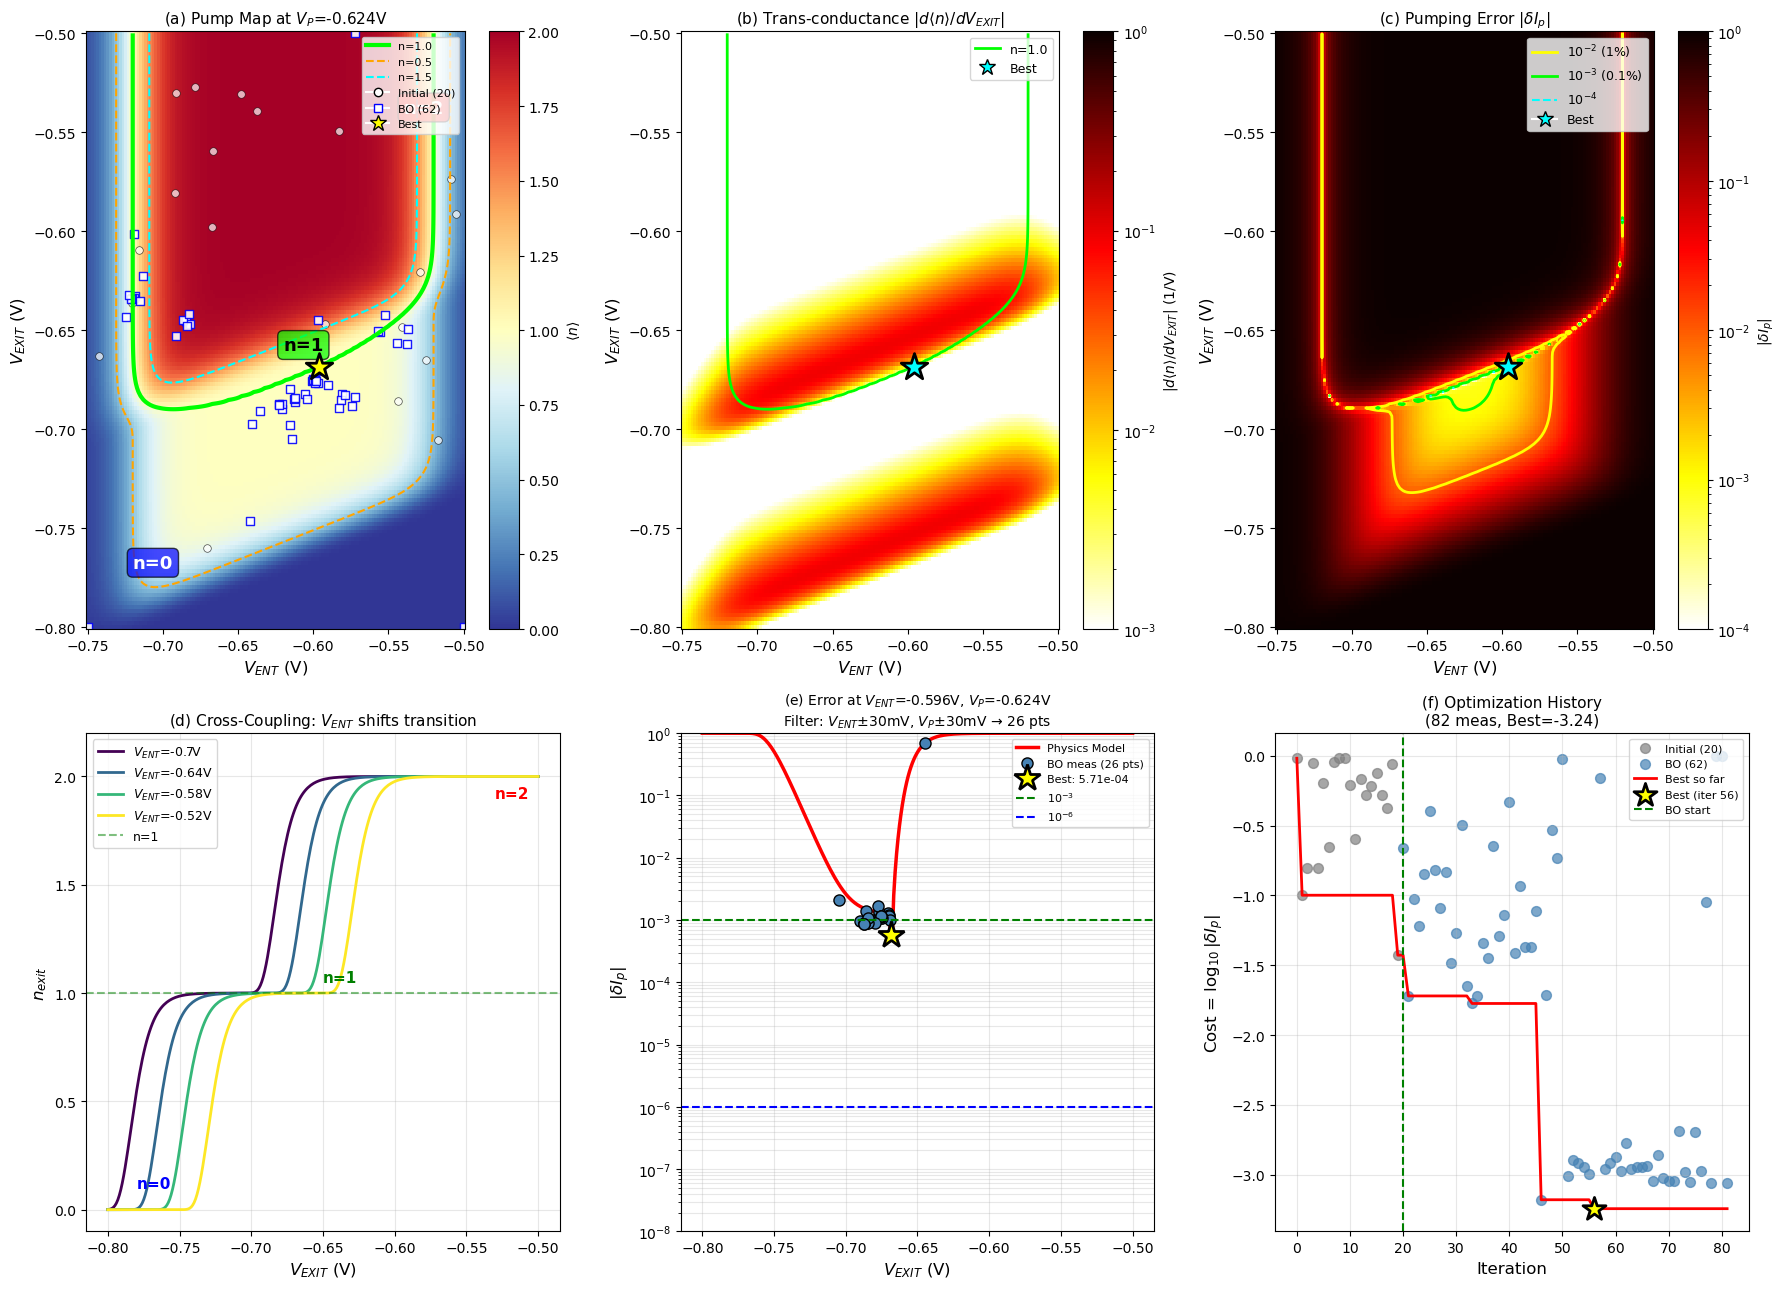

OPTIMIZATION RESULTS
Total measurements: 82 (20 initial + 62 BO)
Filtered for panel (e): 26 pts (Filter: $V_{ENT}$±30mV, $V_P$±30mV)
Best point: V_ENT=-0.5960V, V_P=-0.6237V, V_EXIT=-0.6686V
Best <n> = 0.999429
Best |δIp| = 5.71e-04


In [5]:
# Cell 5: Run BO Experiment

def run_experiment():
    cfg = Config()
    instr = InstrumentController(cfg)
    bo = BayesianOptimizer(cfg.bounds)
    logger = DataLogger(cfg)
    early_stop = EarlyStopping(patience=cfg.early_stop_patience)
    
    X_hist, y_hist, n_hist = [], [], []
    
    print('='*60)
    print('BAYESIAN OPTIMIZATION (V8 Final v2)')
    print('='*60)
    cfg.print_filter_settings()
    
    for i in range(cfg.n_initial_points + cfg.n_iterations):
        if i < cfg.n_initial_points:
            phase = 'INIT'
            x_next = np.random.uniform(cfg.bounds[:, 0], cfg.bounds[:, 1])
        else:
            phase = 'BO'
            bo.fit(X_hist, y_hist, n_hist)
            x_next = bo.suggest()
        
        current = instr.measure_current(*x_next)
        n_avg = current / cfg.target_current
        cost = np.log10(np.abs(n_avg - 1) + 1e-15)
        
        X_hist.append(x_next)
        y_hist.append(cost)
        n_hist.append(n_avg)
        logger.log(i, *x_next, n_avg, cost)
        
        if i % 10 == 0:
            print(f'Iter {i:3d} [{phase}]: V=({x_next[0]:.3f},{x_next[1]:.3f},{x_next[2]:.3f}), n={n_avg:.5f}, cost={cost:.2f}')
        
        if phase == 'BO' and early_stop.update(cost):
            print(f'Early stopping at iter {i}')
            break
    
    bo.fit(X_hist, y_hist, n_hist)
    print('Complete!')
    return X_hist, y_hist, n_hist, cfg, bo


X_hist, y_hist, n_hist, cfg, bo = run_experiment()
best_point, best_n = plot_pump_map_analysis(X_hist, y_hist, n_hist, cfg)

ERROR ANALYSIS - CONSISTENT FILTERING
FILTER SETTINGS
V_ENT tolerance: ±30 mV
V_P tolerance:   ±30 mV
Same filter applied to Cell 5 panel (e) and Cell 6 analysis
Filtered points: 26 / 82 total
  V_ENT tolerance: ±30 mV from -0.596 V
  V_P tolerance:   ±30 mV from -0.624 V


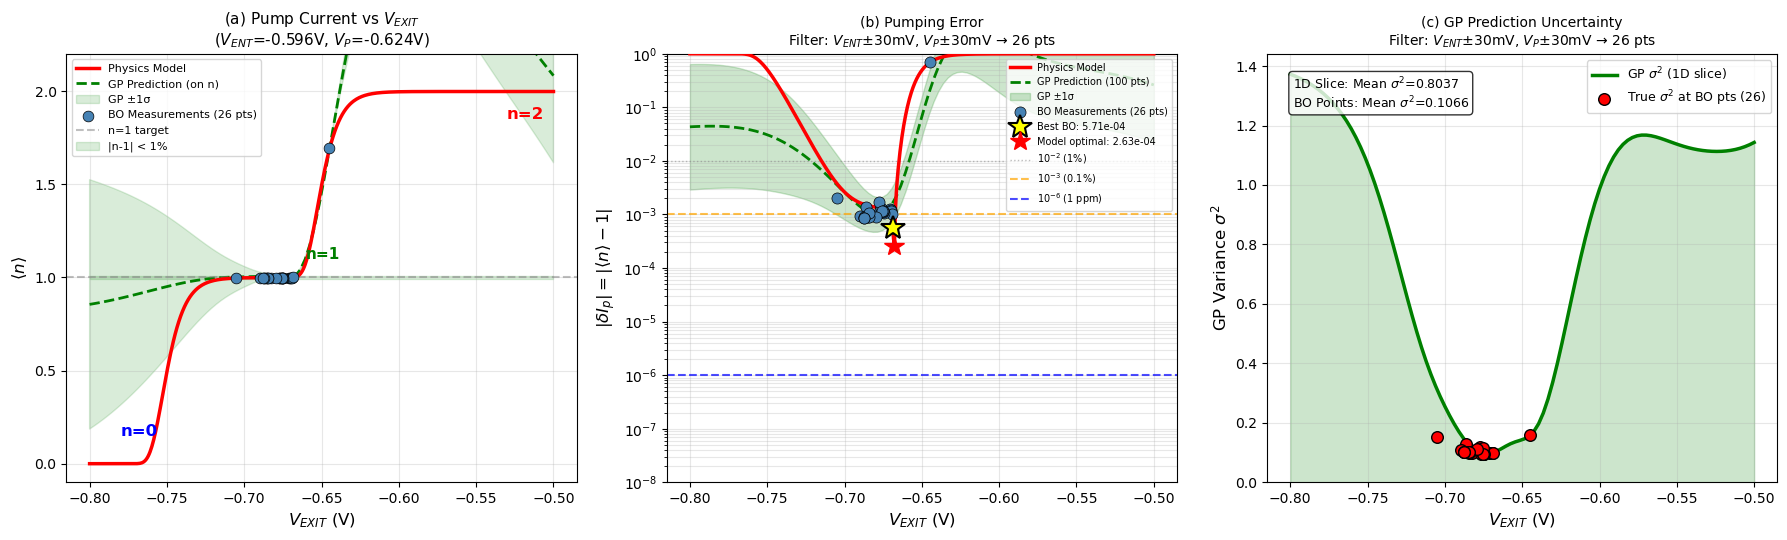

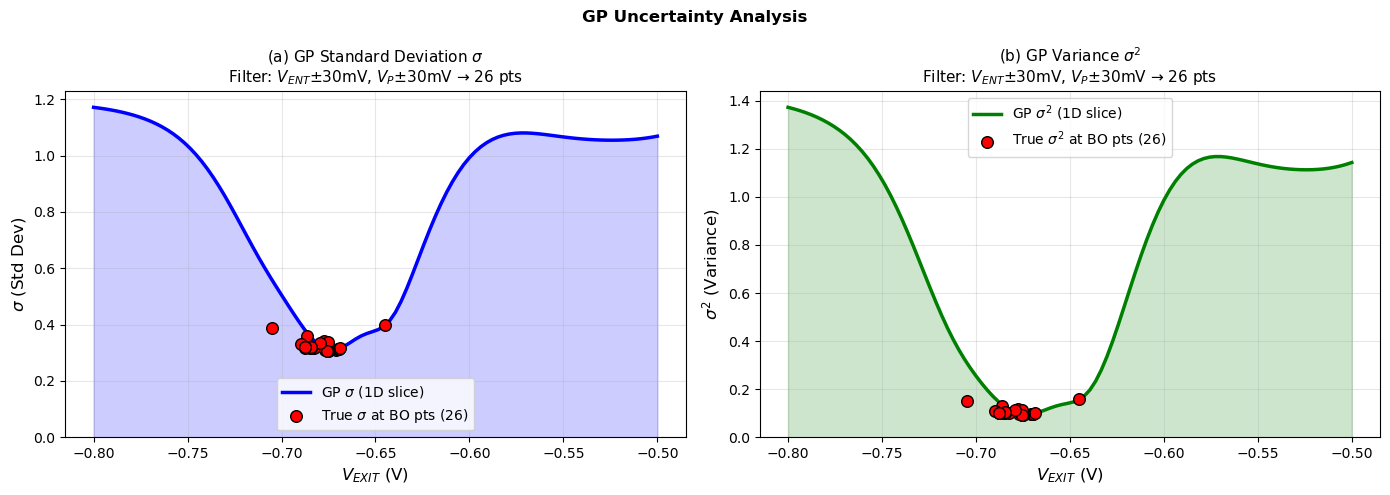

Model data saved: error_analysis_model_data.csv (500 pts)
GP prediction saved: error_analysis_GP_prediction.csv (100 pts)
BO measurements saved: error_analysis_BO_measurements.csv (26 pts)
All BO data saved: all_BO_measurements.csv (82 pts)

Model optimal V_EXIT: -0.6677 V
Model minimum |δIp|: 2.63e-04


In [6]:
# Cell 6: Error Analysis - Uses SAME filter settings

model = OptimizedPumpModel()

print('='*70)
print('ERROR ANALYSIS - CONSISTENT FILTERING')
print('='*70)
cfg.print_filter_settings()
print('Same filter applied to Cell 5 panel (e) and Cell 6 analysis')
print('='*70)

min_v, min_delta = plot_error_analysis_with_GP_variance(
    model, cfg, X_hist, y_hist, n_hist, bo,
    V_ent_fixed=best_point[0],
    V_p_fixed=best_point[1],
    n_gp_points=100,
    save_data=True
)

print(f'\nModel optimal V_EXIT: {min_v:.4f} V')
print(f'Model minimum |δIp|: {min_delta:.2e}')

In [7]:
# Cell 7: Summary

print('='*70)
print('V8 FINAL v2 - SUMMARY')
print('='*70)
print()
print('CONFIGURABLE FILTER PARAMETERS (Cell 2):')
print(f'  Config.V_ENT_TOLERANCE = {cfg.V_ENT_TOLERANCE} ({cfg.V_ENT_TOLERANCE*1000:.0f} mV)')
print(f'  Config.V_P_TOLERANCE   = {cfg.V_P_TOLERANCE} ({cfg.V_P_TOLERANCE*1000:.0f} mV)')
print()
print('To change filter tolerance, modify in Cell 2:')
print('  V_ENT_TOLERANCE = 0.01  # ±10mV')
print('  V_P_TOLERANCE = 0.02    # ±20mV')
print()
print('CONSISTENT FILTERING applied to:')
print('  - Cell 5, panel (e): Error vs V_EXIT')
print('  - Cell 6, panel (a): Pump Current')
print('  - Cell 6, panel (b): Pumping Error')
print('  - Cell 6, panel (c): GP Variance')
print('='*70)

V8 FINAL v2 - SUMMARY

CONFIGURABLE FILTER PARAMETERS (Cell 2):
  Config.V_ENT_TOLERANCE = 0.03 (30 mV)
  Config.V_P_TOLERANCE   = 0.03 (30 mV)

To change filter tolerance, modify in Cell 2:
  V_ENT_TOLERANCE = 0.01  # ±10mV
  V_P_TOLERANCE = 0.02    # ±20mV

CONSISTENT FILTERING applied to:
  - Cell 5, panel (e): Error vs V_EXIT
  - Cell 6, panel (a): Pump Current
  - Cell 6, panel (b): Pumping Error
  - Cell 6, panel (c): GP Variance
